# Inference benchmarks

In [15]:
import tensorflow as tf
from cv2 import imread, resize, cvtColor, COLOR_BGR2RGB
from numpy import expand_dims, array
from datetime import datetime
import onnxruntime as ort
import torch
import os
import pandas as pd
import logging
import matplotlib.pyplot as plt

# Logger configuration

In [2]:
logging.basicConfig(level=logging.INFO)

## Image preprocessing

In [3]:
def get_image(path):
    image = imread(path)
    image = cvtColor(image, COLOR_BGR2RGB)
    image = resize(image, (224, 224))
    image = array(image).astype('float32')
    image = expand_dims(image, axis=0)
    return image

## Loading models

### Keras

In [4]:
model_h5 = tf.keras.models.load_model('../weights/vgg-face.h5')
print(f"Keras model running on GPU: {tf.test.is_gpu_available()}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Keras model running on GPU: True


### ONNX

In [5]:
sess = ort.InferenceSession('../weights/vgg-face.onnx')
input_name = sess.get_inputs()[0].name
print(f"ONNX model running on: {ort.get_device()}")

ONNX model running on: GPU


### PyTorch

In [6]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pt = torch.load("../weights/vgg-face.pt").to(device)
model_pt.eval()
print(f"PyTorch model running on: {device}")

INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='Erf', version=13)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='Erf', version=9)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSigmoid', version=6)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSigmoid', version=1)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='HardSwish', version=14)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='LeakyRelu', version=16)
INFO:onnx2torch.node_converters.registry:Operation converter registered OperationDescription(domain='', operation_type='LeakyRelu', version=6)
INFO

PyTorch model running on: cuda:0


## Getting dataset

In [7]:
dataset_root = '../training/classifier/dataset/val/'

file_paths = []	
for path, subdirs, files in os.walk(dataset_root):
    for name in files:
        file_paths.append(os.path.join(path, name))

df: pd.DataFrame = pd.DataFrame(file_paths, columns=['path'])
df = df[df['path'].str.endswith('.jpg')]
df

,path
0,../training/classifier/dataset/val/Angelina Jo...
1,../training/classifier/dataset/val/Angelina Jo...
2,../training/classifier/dataset/val/Angelina Jo...
3,../training/classifier/dataset/val/Angelina Jo...
4,../training/classifier/dataset/val/Angelina Jo...
...,...
159,../training/classifier/dataset/val/Will Smith\...
160,../training/classifier/dataset/val/Will Smith\...
161,../training/classifier/dataset/val/Will Smith\...
162,../training/classifier/dataset/val/Will Smith\...


## Inferences

In [12]:
def keras_inference(image):
    start_time = datetime.now()
    predictions_h5 = model_h5.predict(image, verbose=0)
    end_time = datetime.now()
    keras_elapsed_time = end_time - start_time
    return predictions_h5, keras_elapsed_time.total_seconds()*1000

def onnx_inference(image):
    start_time = datetime.now()
    predictions_onnx = sess.run(None, {input_name: image})
    end_time = datetime.now()
    onnx_elapsed_time = end_time - start_time
    return predictions_onnx, onnx_elapsed_time.total_seconds()*1000

def pytorch_inference(image):
    with torch.no_grad():
        start_time = datetime.now()
        image = torch.from_numpy(image).to(device)
        predictions_pt = model_pt(image)
        end_time = datetime.now()
        pytorch_elapsed_time = end_time - start_time
        return predictions_pt, pytorch_elapsed_time.total_seconds()*1000

In [13]:
keras_prediction_times = []
onnx_prediction_times = []
pytorch_prediction_times = []

# Warmup
image = get_image(df.iloc[0]['path'])
keras_inference(image)
onnx_inference(image)
pytorch_inference(image)


for index, row in df.iterrows():
    logging.info(f"Processing {index} of {len(df)}: {row['path']}")
    image = get_image(row['path'])

    keras_prediction, keras_elapsed_time = keras_inference(image)
    onnx_prediction, onnx_elapsed_time = onnx_inference(image)
    pytorch_prediction, pytorch_elapsed_time = pytorch_inference(image)

    keras_prediction_times.append(keras_elapsed_time)
    onnx_prediction_times.append(onnx_elapsed_time)
    pytorch_prediction_times.append(pytorch_elapsed_time)


df['keras_prediction_times'] = keras_prediction_times
df['onnx_prediction_times'] = onnx_prediction_times
df['pytorch_prediction_times'] = pytorch_prediction_times
df

INFO:root:Processing 0 of 164: ../training/classifier/dataset/val/Angelina Jolie\018_fcafe1a8.jpg
INFO:root:Processing 1 of 164: ../training/classifier/dataset/val/Angelina Jolie\022_b497b92e.jpg
INFO:root:Processing 2 of 164: ../training/classifier/dataset/val/Angelina Jolie\037_62d00a09.jpg
INFO:root:Processing 3 of 164: ../training/classifier/dataset/val/Angelina Jolie\045_c560251e.jpg
INFO:root:Processing 4 of 164: ../training/classifier/dataset/val/Angelina Jolie\050_7c5b026c.jpg
INFO:root:Processing 5 of 164: ../training/classifier/dataset/val/Angelina Jolie\084_da751ddd.jpg
INFO:root:Processing 6 of 164: ../training/classifier/dataset/val/Angelina Jolie\087_f325890f.jpg
INFO:root:Processing 7 of 164: ../training/classifier/dataset/val/Angelina Jolie\090_da55509f.jpg
INFO:root:Processing 8 of 164: ../training/classifier/dataset/val/Angelina Jolie\092_26130bb1.jpg
INFO:root:Processing 9 of 164: ../training/classifier/dataset/val/Angelina Jolie\095_0be163a1.jpg
INFO:root:Processing

,path,keras_prediction_times,onnx_prediction_times,pytorch_prediction_times
0,../training/classifier/dataset/val/Angelina Jo...,139.725,118.185,33.019
1,../training/classifier/dataset/val/Angelina Jo...,138.994,128.001,33.951
2,../training/classifier/dataset/val/Angelina Jo...,137.997,131.046,34.995
3,../training/classifier/dataset/val/Angelina Jo...,139.998,113.136,30.999
4,../training/classifier/dataset/val/Angelina Jo...,129.998,130.001,32.036
...,...,...,...,...
159,../training/classifier/dataset/val/Will Smith\...,160.716,126.949,37.005
160,../training/classifier/dataset/val/Will Smith\...,148.002,102.037,35.999
161,../training/classifier/dataset/val/Will Smith\...,150.998,132.041,32.955
162,../training/classifier/dataset/val/Will Smith\...,154.000,130.955,32.001


## Results analysis

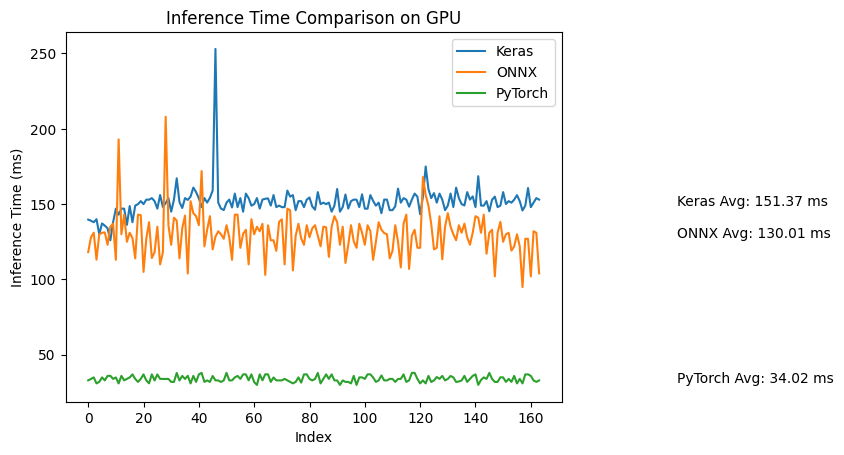

In [20]:
# Plotting the curves
plt.plot(df.index, df['keras_prediction_times'], label='Keras')
plt.plot(df.index, df['onnx_prediction_times'], label='ONNX')
plt.plot(df.index, df['pytorch_prediction_times'], label='PyTorch')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Inference Time (ms)')
plt.title('Inference Time Comparison on GPU')
plt.legend()

# Calculate the average values
keras_avg = df['keras_prediction_times'].mean()
onnx_avg = df['onnx_prediction_times'].mean()
pytorch_avg = df['pytorch_prediction_times'].mean()

# Display the average values
plt.text(df.index[-1] +50, keras_avg, f'Keras Avg: {keras_avg:.2f} ms', va='center')
plt.text(df.index[-1] + 50, onnx_avg, f'ONNX Avg: {onnx_avg:.2f} ms', va='center')
plt.text(df.index[-1] + 50, pytorch_avg, f'PyTorch Avg: {pytorch_avg:.2f} ms', va='center')

# Displaying the plot
plt.show()